In [86]:
import numpy as np
import json
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from itertools import combinations 
import matplotlib.transforms
import random
import math

import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModel

import spacy
from spacy.symbols import ORTH

from scipy.stats import ks_2samp

## Dataset preprocessing

### Loading BERT

In [87]:
model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name, output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Preparing text for BERT (coherent and not coherent)

In [88]:
utts = [] #utterances to extract to build non coherent dialogues
lengths = [] #number of utterances per dialogue to extract to build non coherent dialogues

#preparing input for attention extraction
lst_dict = [] #list of dict instances containing BERT preprocessed text and plain text
with open('./data/EMNLP_dataset/dialogues_text.txt', 'r') as f:
    lines = f.readlines()
    for l in tqdm(lines):
        bert_tokenized = bert_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        if len(bert_tokenized) < 513:
            lst_dict.append({'bert': "[CLS] " + l.replace("__eou__", "[SEP]").replace("\n", "").replace("'", " ' "), 
                             'txt': l.replace("\n", "").replace("'", " ' ")})
            
            utts += [utt.strip() for utt in lst_dict[-1]['bert'][5:].split("[SEP]") if (utt.strip() not in ["", " "])]
            lengths.append(lst_dict[-1]['bert'].count("[SEP]"))

#preparing non coherent dialogues
dialogues = ""
utts_list = random.sample(utts, len(utts)) #random permutation over utterances

#preparing text for non coherent dialogues
d_iterator = 0
for i in tqdm(np.arange(len(lengths))):
    dialogue_length = lengths[i]
    dialogue = ""
    for _ in np.arange(dialogue_length):
        dialogue += utts_list[d_iterator] + "__eou__"
        d_iterator += 1
    dialogues += dialogue +"\n"

#saving non coherent dialogues
with open('./data/EMNLP_dataset/dialogues_text_not_coherent.txt', 'w') as f:
    f.write(dialogues)
    
#preparing for attention extraction - non coherent dialogues
lst_dict_not_coherent = []
with open('./data/EMNLP_dataset/dialogues_text_not_coherent.txt', 'r') as f:
    lines = f.readlines()
    for l in tqdm(lines):
        bert_tokenized = bert_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        if len(bert_tokenized) < 513:
            lst_dict_not_coherent.append({'bert': "[CLS] " + l.replace("__eou__", "[SEP]").replace("\n", "").replace("'", " ' "),
                             'txt': l.replace("\n", "").replace("'", " ' ")})

100%|██████████| 13086/13086 [00:04<00:00, 2741.75it/s]


In [90]:
lst_dict[0]

{'bert': "[CLS] The kitchen stinks . [SEP] I ' ll throw out the garbage . [SEP]",
 'txt': "The kitchen stinks . __eou__ I ' ll throw out the garbage . __eou__"}

### Extracting attentions

In [111]:
def from_torch_tensor2_numpy(tensor):
    arr = np.empty((len(tensor), tensor[0].size()[1], tensor[0].size()[-1], tensor[0].size()[-1]))
    for i, item in enumerate(tensor):
        arr[i] = item[0].cpu().detach().numpy()
    return arr

#translate BERT tokens into spacy tokens and performs alignments
def from_tkn_to_spacy(dict_txt, tokenizer, model_type):
    txt = dict_txt['txt']
    tkn_spacy, tkn_spacy_aligned = [], ["[CLS]"] if  model_type == 'bert' else []
    head_spacy, head_spacy_aligned = [], [None] if  model_type == 'bert' else []
    word_spacy, word_spacy_aligned =  [], ["[CLS]"] if  model_type == 'bert' else []
    pos_spacy, pos_spacy_aligned =  [], ["[CLS]"] if  model_type == 'bert' else []
    for utt in txt.split("__eou__"):
        doc = nlp(utt)
        for tkn in doc:
            if tkn.text.strip() !="":
                tokenized = tokenizer.convert_ids_to_tokens(tokenizer.encode(tkn.text, return_tensors = 'pt', add_special_tokens = False)[0])
                for t in tokenized:
                    if t[:2] != "##":
                        tkn_spacy.append(tkn.dep_)
                        head_spacy.append(tkn.head.i)
                        word_spacy.append(tkn.text)
                        pos_spacy.append(tkn.pos_)
                    tkn_spacy_aligned.append(tkn.dep_)
                    head_spacy_aligned.append(tkn.head.i)
                    word_spacy_aligned.append(tkn.text)
                    pos_spacy_aligned.append(tkn.pos_)
        
        tkn_spacy_aligned.append("[SEP]")
        word_spacy_aligned.append("[SEP]")
        head_spacy_aligned.append("[SEP]")
        pos_spacy_aligned.append("[SEP]")
    
    tkn_spacy = tkn_spacy[:-1] if model_type == 'bert' else tkn_spacy
    tkn_spacy_aligned = tkn_spacy_aligned[:-1] if model_type == 'bert' else tkn_spacy_aligned
    word_spacy_aligned = word_spacy_aligned[:-1] if model_type == 'bert' else word_spacy_aligned
    head_spacy_aligned = head_spacy_aligned[:-1] if model_type == 'bert' else head_spacy_aligned
    pos_spacy_aligned = pos_spacy_aligned[:-1] if model_type == 'bert' else pos_spacy_aligned
    return tkn_spacy, word_spacy, head_spacy, pos_spacy, tkn_spacy_aligned, word_spacy_aligned, head_spacy_aligned, pos_spacy_aligned

#spacy initialization
nlp = spacy.load("en_core_web_sm")
special_case = [{ORTH: "gonna"}]
nlp.tokenizer.add_special_case("gonna", special_case)
special_case = [{ORTH: "gotta"}]
nlp.tokenizer.add_special_case("gotta", special_case)
special_case = [{ORTH: "cannot"}]
nlp.tokenizer.add_special_case("cannot", special_case)

#primary data structures to save attentions
models = ['bert'] #ready to be extended
keys = [('bert', bert_tokenizer, 'bert', bert_model)]
attention_dicts = {
    k: [] for k in models
}
attention_dicts_not_coherent = {
    k: [] for k in models
}

In [112]:
#to run if there is not something saved
for k, tokenizer, model_type, model in keys:
    for item in tqdm(lst_dict[:300]):
        inputs = tokenizer.encode(item[model_type], 
                                return_tensors = 'pt', 
                                add_special_tokens = False)
        outputs = model(inputs)
        deps, w, h, pos, deps_a, w_a, h_a, pos_a = from_tkn_to_spacy(item, tokenizer, model_type)
        attention_dicts[k].append({'attns' : from_torch_tensor2_numpy(outputs[-1]),
                                'tokens' : tokenizer.convert_ids_to_tokens(inputs[0]),
                                'relns': deps,
                                'words': w,
                                'heads': h,
                                'pos' : pos,
                                'relns_aligned':deps_a,
                                'words_aligned': w_a,
                                'heads_aligned': h_a,
                                'pos_aligned' : pos_a})

#save
for k in attention_dicts:
    output = open(f'./data/data_attention_annotated{k}.pkl', 'wb')
    pickle.dump(attention_dicts[k], output)
    output.close()

100%|██████████| 300/300 [00:25<00:00, 11.70it/s]


In [113]:
#to run if there is not something saved
for k, tokenizer, model_type, model in keys:
    for item in tqdm(lst_dict_not_coherent[:300]):
        inputs = tokenizer.encode(item[model_type], 
                                return_tensors = 'pt', 
                                add_special_tokens = False)
        outputs = model(inputs)
        deps, w, h, pos, deps_a, w_a, h_a, pos_a = from_tkn_to_spacy(item, tokenizer, model_type)
        attention_dicts_not_coherent[k].append({'attns' : from_torch_tensor2_numpy(outputs[-1]),
                                'tokens' : tokenizer.convert_ids_to_tokens(inputs[0]),
                                'relns': deps,
                                'words': w,
                                'heads': h,
                                'pos' : pos,
                                'relns_aligned':deps_a,
                                'words_aligned': w_a,
                                'heads_aligned': h_a,
                                'pos_aligned' : pos_a})

#save
for k in tqdm(attention_dicts_not_coherent):
    output = open(f'./data/data_attention_annotated_not_coherent{k}.pkl', 'wb')
    pickle.dump(attention_dicts_not_coherent[k], output)
    output.close()

100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


## Attention analysis

### Loading model and data

In [3]:
model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name, output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def data_iterator(data):
  for i, doc in enumerate(data):
    if i % 100 == 0 or i == len(data) - 1:
      print("{:.1f}% done".format(100.0 * (i + 1) / len(data)))
    yield doc["tokens"], np.array(doc["attns"]), doc["words"], doc["relns"], doc["heads"], doc["pos"], doc["relns_aligned"], doc["words_aligned"], doc["heads_aligned"], doc["pos_aligned"]
    
def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

In [5]:
#primary data structures to save attentions
models = ['bert'] #ready to be extended
keys = [('bert', bert_tokenizer, 'bert', bert_model)]
attention_dicts = {
    k: [] for k in models
}
attention_dicts_not_coherent = {
    k: [] for k in models
}

for k in attention_dicts:
    attention_dicts[k] = load_pickle(f'./data/data_attention_annotated{k}.pkl')
    
for k in attention_dicts_not_coherent:
    attention_dicts_not_coherent[k] = load_pickle(f'./data/data_attention_annotated_not_coherent{k}.pkl')

### Aggregating attention (with or without filters)

In [6]:
dep_keys = np.unique([k for attn_dict in attention_dicts for example in attention_dicts[attn_dict] for k in example['relns_aligned']])
pos_keys = np.unique([k for attn_dict in attention_dicts for example in attention_dicts[attn_dict] for k in example['pos_aligned']])
positional_keys = np.array(["self", "right", "left", "sep_sep","rest_sep", "ALL", "utt_with_current", "utt_without_current", "no_cls_sep_punct"])
special_tkns = np.concatenate((dep_keys, pos_keys, positional_keys))

In [64]:
def compute_avg_attn(attn_dict):
  avg_attns = {
      k: np.zeros((12, 12)) for k in special_tkns
  }

  avg_attention_dicts = {
      k: avg_attns.copy() for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  distribution_attentions_dicts = {
    k: {m : [] for m in special_tkns} for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  pointwise_distribution_attentions_dicts = {
    k: [[{'lower':[], 'upper':[]} for _ in np.arange(12)] for _ in np.arange(12)] for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  for k in avg_attention_dicts:
      data = attn_dict[k]
      n_docs = len(attn_dict[k])
      
      n_elem = 0
      print("Computing token stats")
      for tokens, attns, _, _, _, _, relns_aligned, words_aligned, _, pos_aligned  in data_iterator(data):
        n_tokens = tf.shape(attns)[-1]
        
        #check if alignment is correct
        if n_tokens != len(relns_aligned):
          print(f"Not aligned n. {n_elem}")
          print(relns_aligned[-1])
          for i in np.arange(len(relns_aligned)):
            print(tokens[i], words_aligned[i], relns_aligned[i])
          return
        
        n_elem+=1
        #sentence filters
        sep_positions = [i for i, item in enumerate(tokens) if item in ['[CLS]', '[SEP]']]
        utt_masks_with_current = []
        utt_masks_without_current = []
        for i in np.arange(len(sep_positions)-1):
          mask_with_current = np.zeros(shape = (n_tokens, n_tokens))
          mask_without_current = np.zeros(shape = (n_tokens, n_tokens))
          for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
              #xor: !=; to avoid attentions to current utterance
              #or: or; to integrate attentions to current utterance
              mask_with_current[v][w] = 1 if ((v >= sep_positions[i] and v <= sep_positions[i+1]) or (w >= sep_positions[i] and w <= sep_positions[i+1]) 
                                   and pos_aligned[v] != 'PUNCT' and tokens[v] not in ['[SEP]', '[CLS]']) else 0
              mask_without_current[v][w] = 1 if ((v >= sep_positions[i] and v <= sep_positions[i+1]) != (w >= sep_positions[i] and w <= sep_positions[i+1]) 
                                   and pos_aligned[v] != 'PUNCT' and tokens[v] not in ['[SEP]', '[CLS]']) else 0
          utt_masks_with_current.append(mask_with_current)
          utt_masks_without_current.append(mask_without_current)
          
        # no cls, sep and punct filter
        mask_no_cls_sep_punct = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
              mask_no_cls_sep_punct[v][w] = 1 if pos_aligned[v] != 'PUNCT' and tokens[v] not in ['[SEP]', '[CLS]'] else 0
        
        #filter for particular tokens: create masks indicating where particular tokens are
        masks_relns = {
          m: np.array([1 if r == m else 0 for r in relns_aligned]) for m in dep_keys
        }
        
        masks_pos = {
          m: np.array([1 if r == m else 0 for r in pos_aligned]) for m in pos_keys
        }
        
        masks = masks_relns | masks_pos 

        seps = masks['[SEP]']
        # create masks indicating which positions are relevant for each key
        sep_seps = np.ones((n_tokens, n_tokens))
        sep_seps *= seps[np.newaxis]
        sep_seps *= seps[:, np.newaxis]

        rest_seps = np.ones((n_tokens, n_tokens))
        rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
        rest_seps *= seps[np.newaxis]
        
        selectors = {
          m: np.tile(masks[m][np.newaxis], [n_tokens, 1]) for m in masks
        }
        
        selectors = selectors | {
          # Return a 2-D array with ones on the diagonal and zeros elsewhere.
            "self": np.eye(n_tokens, n_tokens),
            "right": np.eye(n_tokens, n_tokens, 1),
            "left": np.eye(n_tokens, n_tokens, -1),
          # Construct an array by repeating A the number of times given by reps. n_tokens arrays having one seps[np.newaxis] repetition each
            "sep_sep": sep_seps,
            "rest_sep": rest_seps,
            "ALL" : np.ones(shape=(n_tokens,n_tokens)),
            "utt_with_current": utt_masks_with_current,
            "utt_without_current": utt_masks_without_current,
            "no_cls_sep_punct": mask_no_cls_sep_punct
        }
        
        # get the average attention for each token type
        n_tok = n_tokens ** 2
        for key, selector in selectors.items():
          if key in ['utt_with_current', 'utt_without_current']:
            #get the average attention for each token belonging/not belonging to the current utterance
            total_attn = np.zeros(shape = (12, 12))
            for utt in selector:
              denom = utt.sum(-1).sum(-1)
              #media delle attenzioni esterne
              total_attn += ((attns * utt[np.newaxis, np.newaxis]).sum(-1).sum(-1)) / (denom*len(selector))
          else:
            denom = selector.sum(-1).sum(-1)
            if(denom == 0):
              denom = 1
            total_attn = (
              (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) / denom)
          
          #media delle medie
          avg_attention_dicts[k][key] += total_attn/n_docs
          #distribuzione delle medie
          distribution_attentions_dicts[k][key].append(total_attn)
          
        print(f"Computing pointwise attention {n_elem}", end='\r')
        for l in np.arange(12):
          for h in np.arange(12):
            m = (attns * selectors["no_cls_sep_punct"][np.newaxis, np.newaxis])[l][h]
            pointwise_distribution_attentions_dicts[k][l][h]['lower'].append(np.quantile(m,0.9))
            pointwise_distribution_attentions_dicts[k][l][h]['upper'].append(np.quantile(m,1))
          
  return avg_attention_dicts, distribution_attentions_dicts, pointwise_distribution_attentions_dicts

In [65]:
avg_attention_dicts, distrib_attention_dicts, pointwise_distrib_attention_dicts = compute_avg_attn(attention_dicts)
for k in tqdm(avg_attention_dicts):
    output = open(f'./data/avg_attention_dicts{k}.pkl', 'wb')
    pickle.dump(avg_attention_dicts[k], output)
    output.close()
    output = open(f'./data/distrib_attention_dicts{k}.pkl', 'wb')
    pickle.dump(distrib_attention_dicts[k], output)
    output.close()
    output = open(f'./data/pointwise_distrib_attention_dicts{k}.pkl', 'wb')
    pickle.dump(pointwise_distrib_attention_dicts[k], output)
    output.close()

Computing token stats
0.3% done
33.7% donepointwise attention 100
67.0% donepointwise attention 200
100.0% doneointwise attention 299


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


In [31]:
avg_attention_not_coherent_dicts, distrib_attention_not_coherent_dicts, _ = compute_avg_attn(attention_dicts_not_coherent)
for k in tqdm(avg_attention_not_coherent_dicts):
    output = open(f'./data/avg_attention_not_coherent_dicts{k}.pkl', 'wb')
    pickle.dump(avg_attention_not_coherent_dicts[k], output)
    output.close()
    output = open(f'./data/distrib_attention_not_coherent_dicts{k}.pkl', 'wb')
    pickle.dump(distrib_attention_not_coherent_dicts[k], output)
    output.close()

Computing token stats
0.3% done
33.7% donepointwise attention 100
67.0% donepointwise attention 200
100.0% doneointwise attention 299


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


### Analysing aggregated attention

In [186]:
def plot_avg_matrices(attn_dict, model_name, diffs = False):
    #magenta -> negativo
    #verde -> positivo
    #bianco -> 0
    n_elem = (10 * (int(len(special_tkns)/10) + 1)) if len(special_tkns)%10 !=0 else (10 * (int(len(special_tkns)/10)))
    n_row = int(n_elem/5)
    n_col = 5
    fig, ax = plt.subplots(n_row, n_col, figsize=(20,70))
    plt.set_cmap('PiYG')
    fig.suptitle(model_name, fontsize=16)
    
    I, J = np.unravel_index(np.arange(n_elem), shape = (n_row, n_col))
    for k, t in enumerate(special_tkns):
        i, j = I[k], J[k]
        if diffs:
            d = np.round(np.sum(np.sum(np.absolute(attn_dict[t]), axis = -1), axis = -1), 4)
            ax[i][j].set_title(f"{t}; Diff: {d}")
        else:
            ax[i][j].set_title(f"{t}")
        ax[i][j].set_xlabel("Heads")
        ax[i][j].set_ylabel("Layers")
        ax[i][j].set_xticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
        ax[i][j].set_yticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
        # apply offset transform to all x ticklabels.
        # Create offset transform by 5 points in x direction
        dx = -8/72.; dy = 0/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[i][j].xaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
        
        dx = 0/72.; dy = 8/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[i][j].yaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
        ax[i][j].imshow(attn_dict[t])
        

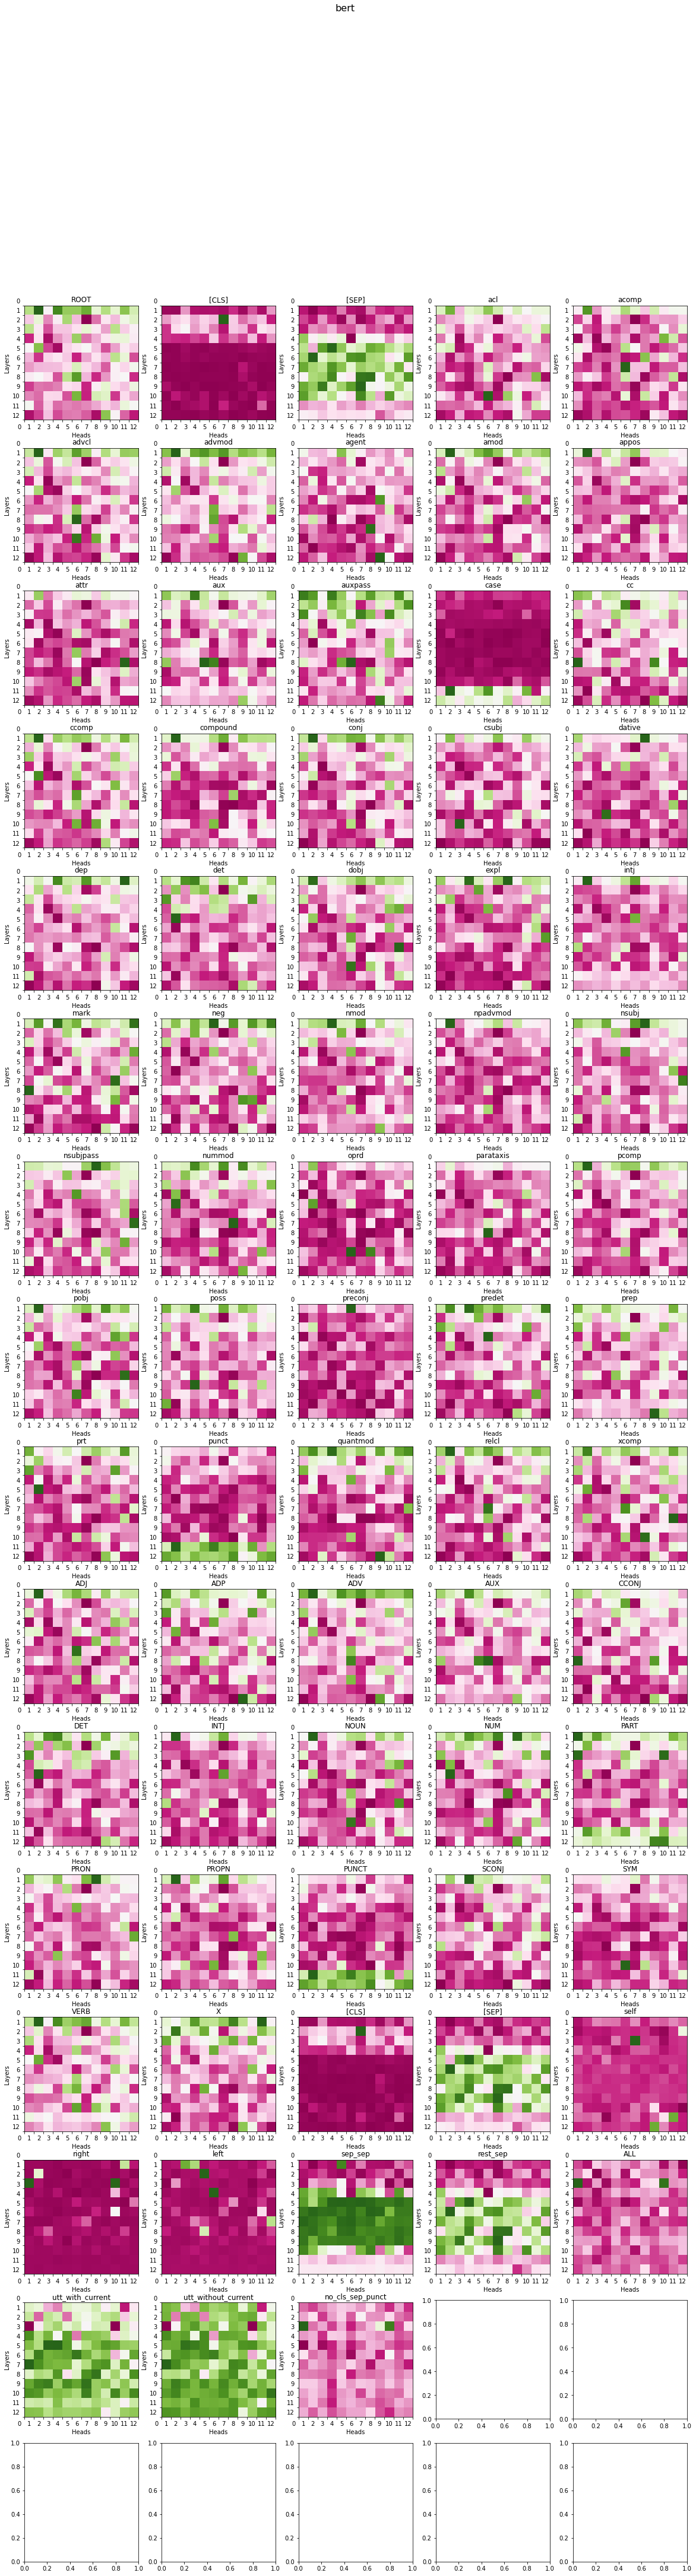

In [187]:
model = list(avg_attention_dicts.keys())[0]
plot_avg_matrices(avg_attention_dicts[model], model)

In [188]:
def plot_distrib_difference(attn_dict1, attn_dict2, model_name = 'bert'):
    #magenta -> negativo
    #verde -> positivo
    #bianco -> 0
    n_elem = (10 * (int(len(special_tkns)/10) + 1)) if len(special_tkns)%10 !=0 else (10 * (int(len(special_tkns)/10)))
    n_row = int(n_elem/5)
    n_col = 5
    fig, ax = plt.subplots(n_row, n_col, figsize=(20,70))
    plt.set_cmap('PiYG')
    fig.suptitle(model_name, fontsize=16)
    
    I, J = np.unravel_index(np.arange(n_elem), shape = (n_row, n_col))
    for k, t in enumerate(special_tkns):
        i, j = I[k], J[k]
        ax[i][j].set_title(f"{t}")
        ax[i][j].set_xlabel("Heads")
        ax[i][j].set_ylabel("Layers")
        ax[i][j].set_xticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
        ax[i][j].set_yticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
        # apply offset transform to all x ticklabels.
        # Create offset transform by 5 points in x direction
        dx = -8/72.; dy = 0/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[i][j].xaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
        
        dx = 0/72.; dy = 8/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[i][j].yaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
        mat = np.zeros((12,12))
        for l in np.arange(12):
            for h in np.arange(12):
                p = ks_2samp(attn_dict1[model_name][t][l][h], attn_dict2[model_name][t][l][h]).pvalue
                mat[l][h] = -1 if p < 0.01 else 1
        ax[i][j].imshow(mat)
        

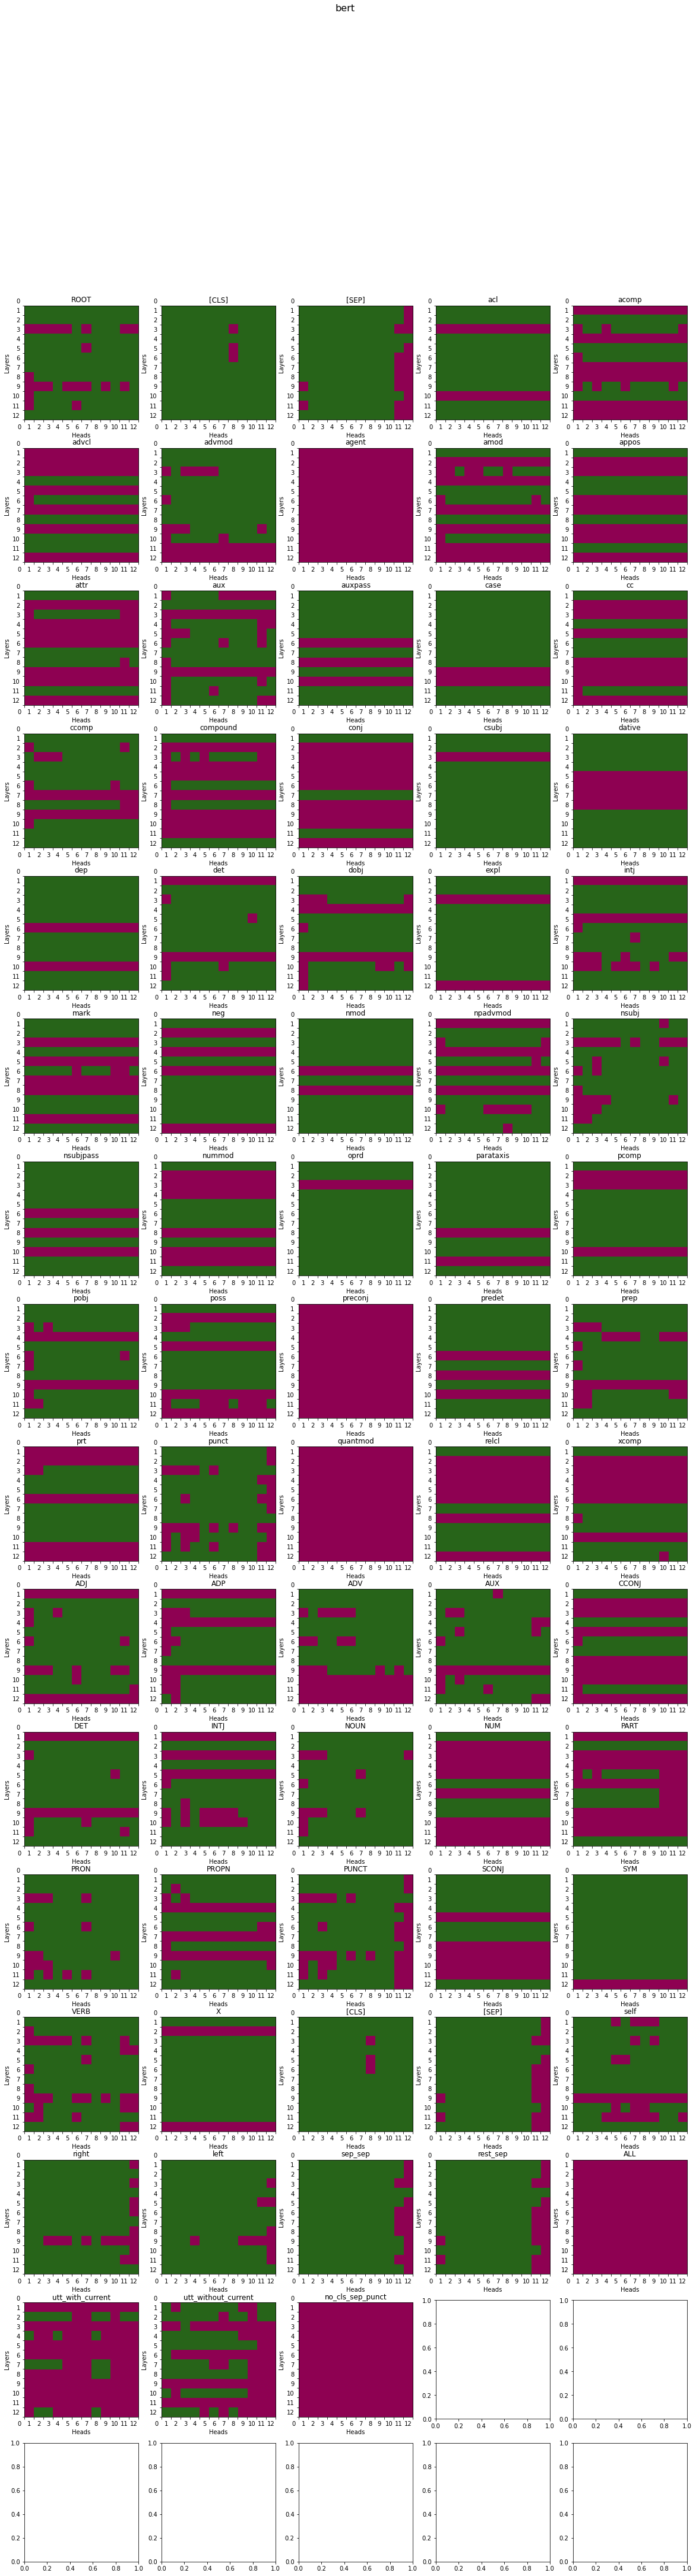

In [189]:
plot_distrib_difference(distrib_attention_dicts, distrib_attention_not_coherent_dicts)

## Attention selection

### Getting 2nd quartile - 4th quartile values

In [66]:
#rilevanti se dalla mediana all'ultimo quantile
relevance_quantiles = {
    k: [[[0, 0] for _ in np.arange(12)] for _ in np.arange(12)] for k in pointwise_distrib_attention_dicts
}

for k in relevance_quantiles:
    for l in np.arange(12):
        for h in np.arange(12):
            relevance_quantiles[k][l][h][0] = np.max(pointwise_distrib_attention_dicts[k][l][h]['lower'])
            relevance_quantiles[k][l][h][1] = np.max(pointwise_distrib_attention_dicts[k][l][h]['upper'])

In [67]:
def select_attn(attn_dict, rel_q):  
  attn_selected = attn_dict.copy()
  
  for k in attn_dict:      
      print("Selecting weights")
      for i, item in enumerate(attn_dict[k]):
        print(f'{np.round(i/len(attn_dict[k]),4)*100}', end='\r')
        n_tokens = int(tf.shape(item['attns'])[-1])
        att_mat = [[[[0 for _ in np.arange(n_tokens)] for _ in np.arange(n_tokens)] for _ in np.arange(12)] for _ in np.arange(12)]
        for l in np.arange(12):
            for h in np.arange(12):
              m1 = item['attns'][l][h] >= rel_q[k][l][h][0]
              m2 = item['attns'][l][h] <= rel_q[k][l][h][1]
              m = m1 * m2
              att_mat[l][h] = item['attns'][l][h] * m
        attn_selected[k][i]['attn_selected'] = att_mat
  return attn_selected


In [68]:
attention_selected = select_attn(attention_dicts, relevance_quantiles)

Selecting weights


In [69]:
relevance_quantiles['bert'][0][0][0]

0.14768967032432556

In [70]:
relevance_quantiles['bert'][0][0][1]

0.4928663671016693

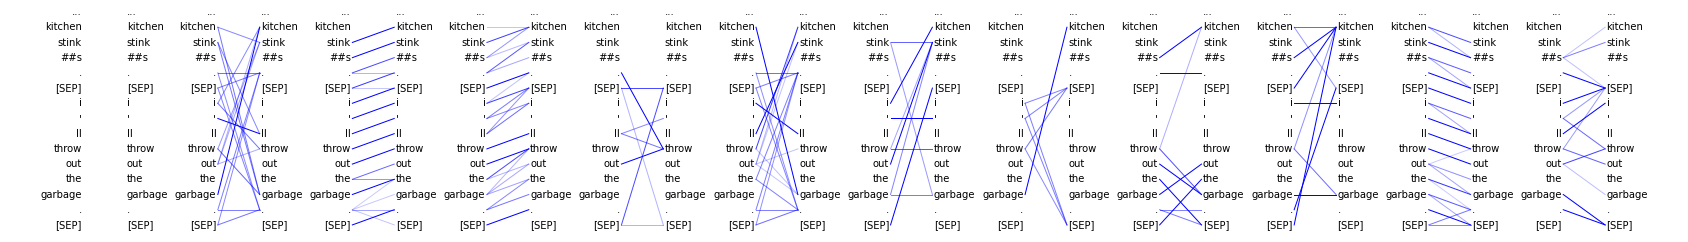

In [84]:
width = 3
example_sep = 3
word_height = 1
pad = 0.1


def plot_attn(example, heads):
  """Plots attention maps for the given example and attention heads."""

  for ei, (layer, head) in enumerate(heads):
    yoffset = 1
    xoffset = ei * width * example_sep

    attn = example["attn_selected"][layer][head][-15:, -15:]
    attn = np.array(attn)
    attn /= (attn.sum(axis=-1, keepdims=True)+0.00000000001)
    words = example["tokens"][-15:]
    words[0] = "..."
    n_words = len(words)

    for position, word in enumerate(words):
      plt.text(xoffset + 0, yoffset - position * word_height, word,
               ha="right", va="center")
      plt.text(xoffset + width, yoffset - position * word_height, word,
               ha="left", va="center")
    for i in range(1, n_words):
      for j in range(1, n_words):
        if not math.isnan(attn[i, j]):
          plt.plot([xoffset + pad, xoffset + width - pad],
                  [yoffset - word_height * i, yoffset - word_height * j],
                  color="blue", linewidth=1, alpha=attn[i, j])

plt.figure(figsize=(30, 4))
plt.axis("off")
plot_attn(attention_selected['bert'][0], [(0, j) for j in np.arange(12)])
plt.show()